In [8]:
import os
import sys
import pathlib
import urllib
import shutil
import re

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


VanillaClassifier(
  (net): MLP(
    (layers): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=256, bias=True)
      (5): BatchNorm1d(256, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=256, out_features=128, bias=True)
      (9): BatchNorm1d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.01)
      (11): Dropout(p=0.1, inplace=False)
      (12): Linear(in_features=128, out_features=10, bias=True)
      (13): Identity()
    )
  )
)
--- EPOCH 1/500 ---
train_batch (Avg. Loss 0.947, Accuracy 76.79): 100%|█| 547/547 [00:12<00:00, 44.
test_batch (Avg. Lo

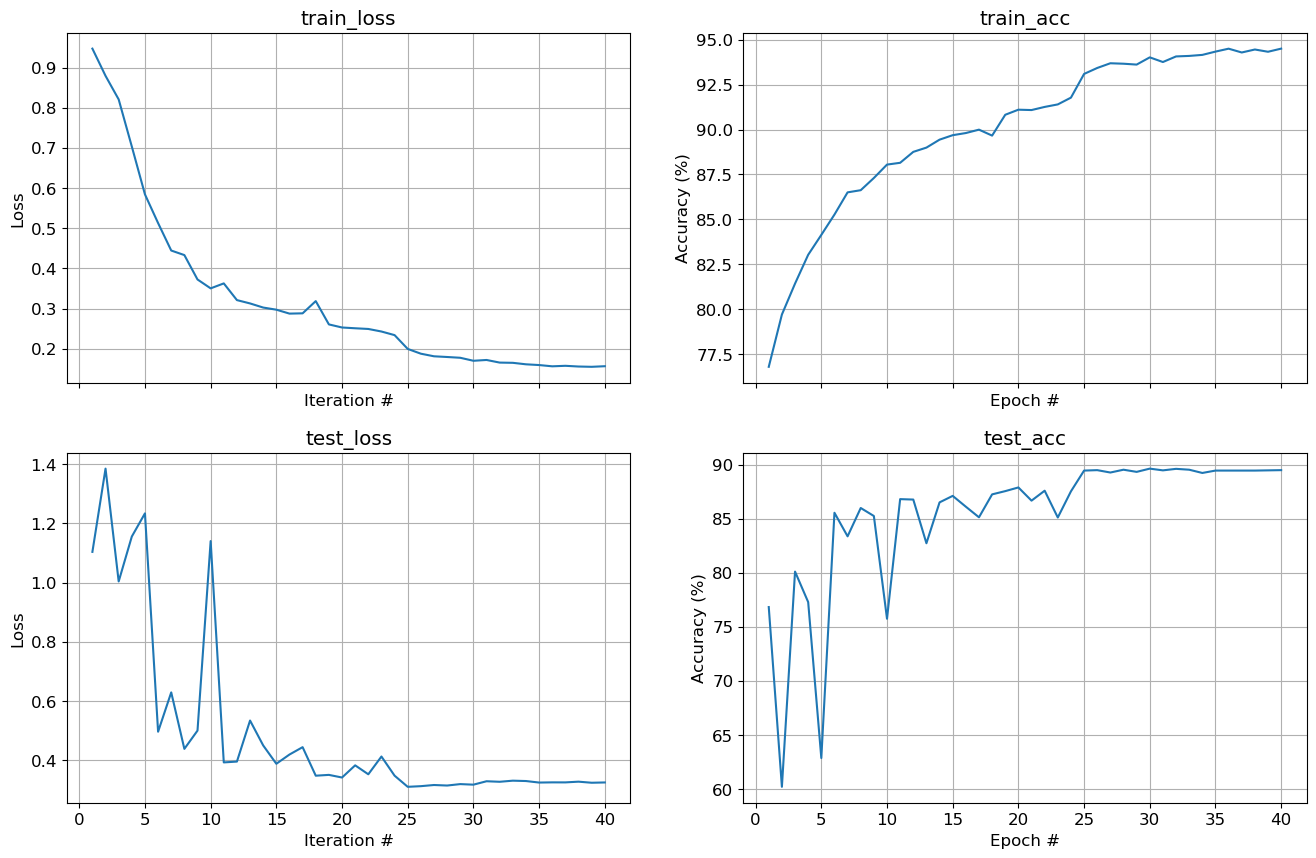

In [12]:
import torch.nn as nn
import torch.optim as optim
from src.training import  AdversarialTrainer
from classifier import VanillaClassifier
from src.utils import set_random_seeds, vec_to_img, get_fmnist_functa
from src.plot import plot_fit

data_path = '/datasets/functaset'
num_classes = 10
in_features = 512
checkpoint_file = 'checkpoints/robust_mlp'
num_epochs = 500
lr = 1e-3
hidden_dims = [512, 256, 128]
p_dropout = 0.1
batch_size = 64
normalization ='batch'
activations = ["lrelu"]*len(hidden_dims)
early_stopping = 10

loss_fn = nn.CrossEntropyLoss()
set_random_seeds(0)
train_functaloader = get_fmnist_functa(data_dir=f"{data_path}/fmnist_train.pkl", mode='train',
                                                   batch_size=batch_size, num_workers=2)
val_functaloader = get_fmnist_functa(data_dir=f"{data_path}/fmnist_val.pkl", mode='test',
                                                 batch_size=batch_size, num_workers=2)

model = VanillaClassifier(in_features=in_features, num_classes=num_classes, hidden_dims=hidden_dims,
                                      nonlins=activations, p_dropout=p_dropout,
                                      normalization=normalization).to(device)
print(model)
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='max', factor=0.1, patience=3, verbose=True)

def post_epoch_fn(epoch, train_res, test_res, verbose):
    scheduler.step(test_res.accuracy)

trainer = AdversarialTrainer(model, loss_fn, optimizer, device=device, randomize=False, linf_bound=0.01,num_pgd_steps=10)

# Train, unless final checkpoint is found
checkpoint_file_final_prefix = f'{checkpoint_file}_final'
checkpoint_file_final = f'{checkpoint_file_final_prefix}.pt'
if os.path.isfile(checkpoint_file_final):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    saved_state = torch.load(checkpoint_file_final, map_location=device)
    model.load_state_dict(saved_state['model_state'])
else:
    try:

        fit_res = trainer.fit(train_functaloader, val_functaloader, num_epochs, max_batches=None,
                                  checkpoints=checkpoint_file_final_prefix, early_stopping=early_stopping, print_every=1,post_epoch_fn=post_epoch_fn )
        fig, axes = plot_fit(fit_res)
        print(f"last checkpoint idx: {fit_res.last_checkpoint_idx}")
    except KeyboardInterrupt as e:
        print('\n *** Training interrupted by user')

In [13]:
import torch

def evaluate_model(model, dataloader, device):
    """
    Evaluates the model on a given dataloader and returns accuracy.
    
    Args:
    - model: The trained model to evaluate.
    - dataloader: DataLoader providing the dataset to evaluate on.
    - device: The device to run the evaluation on ('cuda' or 'cpu').
    
    Returns:
    - accuracy: Accuracy of the model on the provided data.
    """
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    # Disable gradient calculation during inference
    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)

            # Get predicted class (argmax over the outputs)
            predicted = torch.argmax(y_pred, dim=1)

            # Accumulate the total and correct predictions
            correct += (predicted == y).sum().item()
            total += y.size(0)
    
    # Calculate accuracy
    accuracy = correct / total
    return accuracy


In [14]:
train_accuracy = evaluate_model(model, train_functaloader, device)
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')

validation_accuracy = evaluate_model(model, val_functaloader, device)
print(f'Validation Accuracy: {validation_accuracy * 100:.2f}%')

test_functaloader = get_fmnist_functa(data_dir=f"{data_path}/fmnist_test.pkl", mode='test', batch_size=batch_size, num_workers=2)
test_accuracy = evaluate_model(model, test_functaloader, device)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Train Accuracy: 95.44%
Validation Accuracy: 89.48%
Test Accuracy: 88.70%


In [15]:
def attack_classifier(model,
                      loader: DataLoader,
                      criterion,
                      linf_bound,
                      num_pgd_steps = 10,
                      device = "cuda"):
    """
    :param model: your trained classifier model
    :param loader: data loader for input to be perturbed
    :param criterion: The loss criteria you wish to maximize in attack

    1. Initialization: setting up perturbations and the optimizer.
    2. Optimization loop (PGD Steps): Iteratively adjusting perturbations to maximize loss.
    3. Projection: ensuring perturbations remain within specified bounds.
    4. Evaluation: assessing the model's accuracy on perturbed inputs.
    """

    model.eval() #Model should be used in evaluation mode - we are not training any model weights.
    all_preds = []
    all_labels = []
    all_perts = []
    prog_bar = tqdm(loader, total=len(loader))
    for vectors, labels in prog_bar:
        vectors, labels = vectors.to(device), labels.to(device)
        perts = torch.zeros_like(vectors) #initialize the perturbation vectors for current iteration
        
        ''' TODO (1): Your perts tensor currently will not be optimized since torch wasn't instructed to track gradients for it - make torch track its gradients. '''
        perts.requires_grad = True

        ''' TODO (2): Initialize your optimizer, you might need to finetune the learn-rate.
        What should be the set of parameters the optimizer will be changing? Hint: NOT model.parameters()!
        '''
        attack_learning_rate = linf_bound/4
        optimizer = optim.RMSprop([perts], lr=attack_learning_rate, alpha=0.99)
        '''Every step here is one PGD iteration (meaning, one attack optimization step) optimizing your perturbations.
        After the loop below is over you'd have all fully-optimized perturbations for the current batch of vectors.'''
        for step in range(num_pgd_steps): 

            preds = model(vectors + perts) #feed currently perturbed data into the model
            ''' TODO (3):  What's written in this line for the loss is almost correct. Change the code to MAXIMIZE the loss'''
            # optimizer minimize the loss and we want to maximize the loos to make the model misclassify
            # minimizing -loss is equivalent to maximizing the loss
            loss = -criterion(preds, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            ''' TODO (4): Perform needed L_inf norm bound projection. The 'torch.clamp' function could be useful.'''
            # applying the L∞ norm constraint
            # ensures that each element of perts remains within the range [-linf_bound, linf_bound]
            # constraint should not influence gradient calculations.
            with torch.no_grad():
                epsilon = 1e-10
                # Manually clamp the perturbations
                perts.clamp_(-linf_bound+epsilon, linf_bound-epsilon)
                
                
                
            assert perts.abs().max().item() <= linf_bound #If this assert fails, you have a mistake in TODO(4) 
            perts = perts.detach().requires_grad_() #Reset gradient tracking - we don't want to track gradients for norm projection.
            
            
        ''' TODO (5): Accumulate predictions and labels to compute final accuracy for the attacked classifier.
        You can compute final predictions by taking the argmax over the softmax of predictions.'''
        with torch.no_grad():
            perturbed_vectors = vectors + perts
            outputs = model(perturbed_vectors)
            # outputs has a shape of (batch_size, num_classes)
            # for determine the predicted class
            _, predicted = torch.max(outputs, dim=1)

            
        # for each batch.
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_perts.extend(perts.detach().cpu().numpy())
    return all_labels, all_preds, all_perts

In [17]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

model_path = 'checkpoints/robust_mlp_final.pt'
batch_size = 1
data_path = '/datasets/functaset'

set_random_seeds(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)    
       
# the same parameters as used during training
hidden_dims = [512, 256, 128]
activations = ["lrelu"] * len(hidden_dims)
p_dropout = 0.1
normalization = 'batch'


# Instantiate Classifier Model and load weights
classifier = VanillaClassifier(
    in_features=512,
    num_classes=10,
    hidden_dims=hidden_dims,
    nonlins=activations,
    p_dropout=p_dropout,
    normalization=normalization
).to(device)
saved_state = torch.load(model_path, map_location=device)
classifier.load_state_dict(saved_state['model_state'])

test_functaloader = get_fmnist_functa(data_dir=f"{data_path}/fmnist_test.pkl", mode='test',
                                          batch_size=batch_size, num_workers=2)
criterion = nn.CrossEntropyLoss()

linf_bounds = [10**(-i) for i in range(3,7)] + [5*10**(-i) for i in range(3,7)]
print(linf_bounds)
linf_bounds.sort()
print(linf_bounds)
accuracies = []
for bound in linf_bounds:
    print("____________________________________")
    print(f'Attacking with linf_bound={bound}')
    all_labels, all_preds, _ = attack_classifier(classifier, test_functaloader, criterion, bound)
    accuracy = accuracy_score(all_labels, all_preds) * 100
    accuracies.append(accuracy)
    print(f'Accuracy after attack with linf_bound={bound}: {accuracy:.2f}%')
print(accuracies)

cuda
[0.001, 0.0001, 1e-05, 1e-06, 0.005, 0.0005, 5e-05, 4.9999999999999996e-06]
[1e-06, 4.9999999999999996e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005]
____________________________________
Attacking with linf_bound=1e-06


100%|█████████████████████████████████████| 10000/10000 [03:17<00:00, 50.61it/s]


Accuracy after attack with linf_bound=1e-06: 88.70%
____________________________________
Attacking with linf_bound=4.9999999999999996e-06


100%|█████████████████████████████████████| 10000/10000 [03:17<00:00, 50.60it/s]


Accuracy after attack with linf_bound=4.9999999999999996e-06: 87.94%
____________________________________
Attacking with linf_bound=1e-05


100%|█████████████████████████████████████| 10000/10000 [03:17<00:00, 50.60it/s]


Accuracy after attack with linf_bound=1e-05: 87.14%
____________________________________
Attacking with linf_bound=5e-05


100%|█████████████████████████████████████| 10000/10000 [03:17<00:00, 50.70it/s]


Accuracy after attack with linf_bound=5e-05: 78.65%
____________________________________
Attacking with linf_bound=0.0001


100%|█████████████████████████████████████| 10000/10000 [03:17<00:00, 50.71it/s]


Accuracy after attack with linf_bound=0.0001: 67.61%
____________________________________
Attacking with linf_bound=0.0005


100%|█████████████████████████████████████| 10000/10000 [03:17<00:00, 50.67it/s]


Accuracy after attack with linf_bound=0.0005: 53.24%
____________________________________
Attacking with linf_bound=0.001


100%|█████████████████████████████████████| 10000/10000 [03:17<00:00, 50.59it/s]


Accuracy after attack with linf_bound=0.001: 75.91%
____________________________________
Attacking with linf_bound=0.005


100%|█████████████████████████████████████| 10000/10000 [03:18<00:00, 50.42it/s]


Accuracy after attack with linf_bound=0.005: 71.22%
[88.7, 87.94, 87.14, 78.64999999999999, 67.61, 53.239999999999995, 75.91, 71.22]


[88.7, 87.94, 87.14, 78.64999999999999, 67.61, 53.239999999999995, 75.91, 71.22]
[1e-06, 4.9999999999999996e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005]


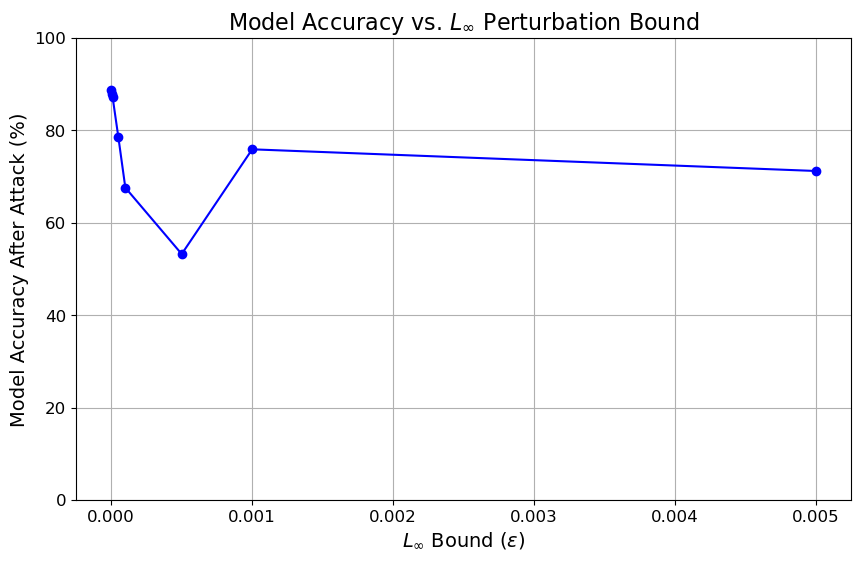

In [18]:
import matplotlib.pyplot as plt

print(accuracies)
print(linf_bounds)
plt.figure(figsize=(10, 6))
plt.plot(linf_bounds, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('$L_{\infty}$ Bound ($\\epsilon$)', fontsize=14)
plt.ylabel('Model Accuracy After Attack (%)', fontsize=14)
plt.title('Model Accuracy vs. $L_{\infty}$ Perturbation Bound', fontsize=16)
plt.ylim(0, 100) 
plt.grid(True)
plt.show()


In [19]:
model_path = 'checkpoints/robust_mlp_final.pt'
batch_size = 1
data_path = '/datasets/functaset'

set_random_seeds(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)    
       
# the same parameters as used during training
hidden_dims = [512, 256, 128]
activations = ["lrelu"] * len(hidden_dims)
p_dropout = 0.1
normalization = "batch"


# Instantiate Classifier Model and load weights
classifier = VanillaClassifier(
    in_features=512,
    num_classes=10,
    hidden_dims=hidden_dims,
    nonlins=activations,
    p_dropout=p_dropout,
    normalization=normalization
).to(device)
saved_state = torch.load(model_path, map_location=device)
classifier.load_state_dict(saved_state['model_state'])

test_functaloader = get_fmnist_functa(data_dir=f"{data_path}/fmnist_test.pkl", mode='test',
                                          batch_size=batch_size, num_workers=2)
criterion = nn.CrossEntropyLoss()


cuda


In [22]:
from sklearn.metrics import confusion_matrix
linf_bound = 0.0001

true_labels, pred_labels, perts = attack_classifier(classifier, test_functaloader, criterion, linf_bound)


100%|█████████████████████████████████████| 10000/10000 [03:19<00:00, 50.24it/s]


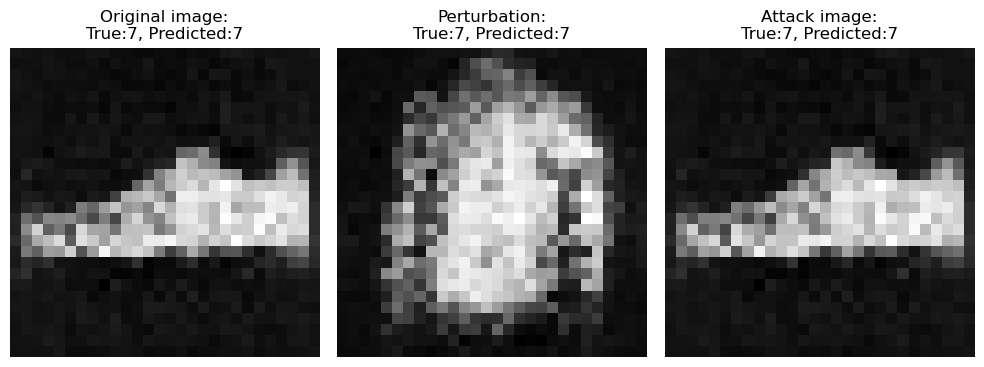

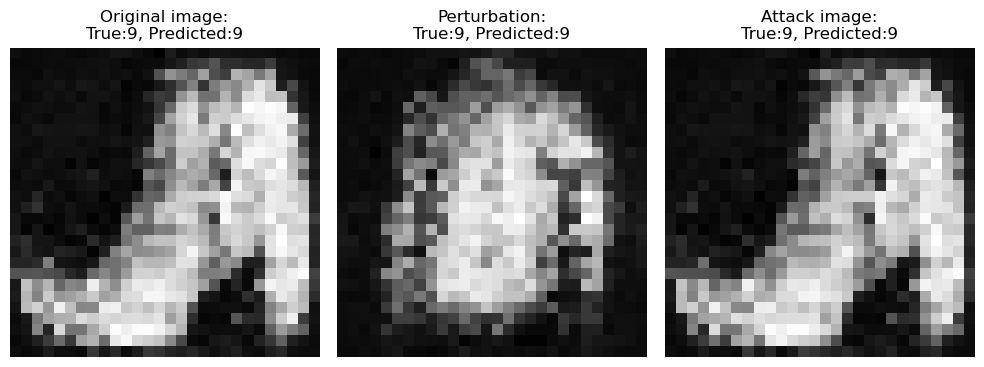

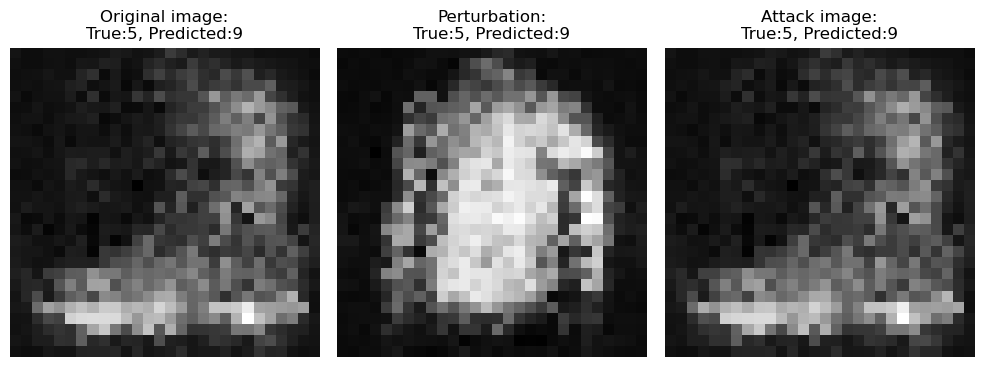

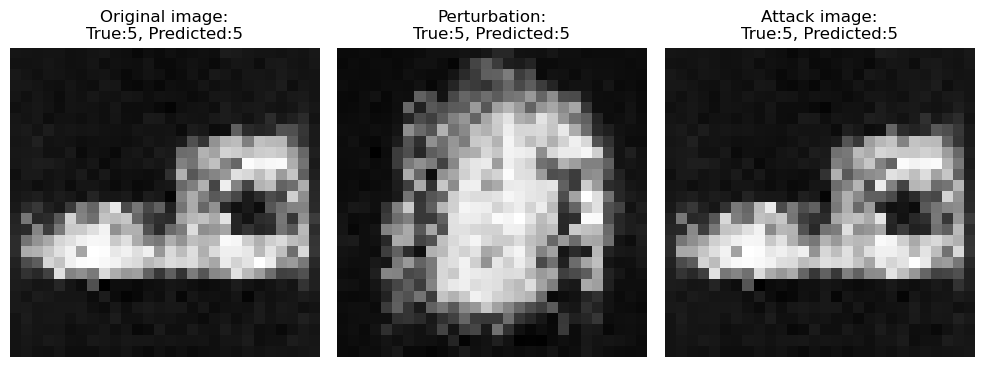

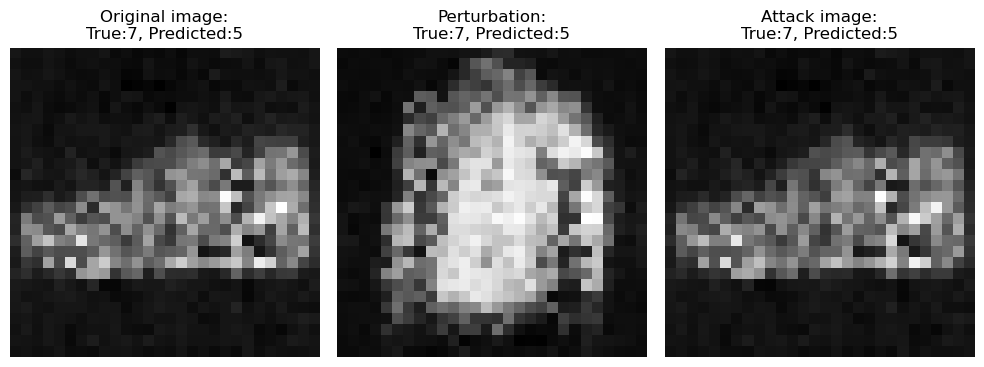

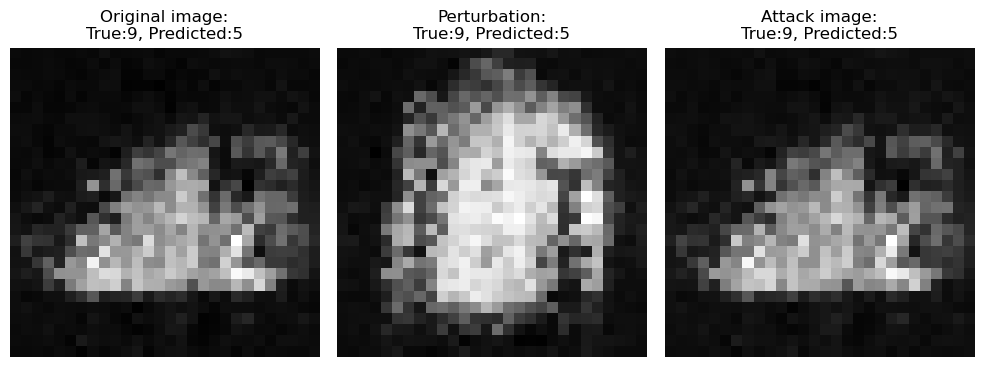

In [27]:
from collections import defaultdict
from src.utils import vec_to_img
import matplotlib.pyplot as plt
from src.SIREN import ModulatedSIREN
from torch.utils.data import Subset
import torch

def plot_images(inr, sample, pert, true_label, pred_label):
    img_tensor = vec_to_img(inr, sample.to(device)).cpu().detach().numpy()  # Original image
    pert_tensor = vec_to_img(inr, pert.to(device)).cpu().detach().numpy()  # Perturbation image
    attack_tensor = vec_to_img(inr, (pert + sample).to(device)).cpu().detach().numpy()  # Attacked image

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))
    axes[0].imshow(img_tensor, cmap='gray')
    axes[0].set_title(f"Original image:\nTrue:{true_label}, Predicted:{pred_label}", fontsize=12)  # Added line break
    axes[0].axis('off')

    axes[1].imshow(pert_tensor, cmap='gray')
    axes[1].set_title(f"Perturbation:\nTrue:{true_label}, Predicted:{pred_label}", fontsize=12)  # Added line break
    axes[1].axis('off')

    axes[2].imshow(attack_tensor, cmap='gray')
    axes[2].set_title(f"Attack image:\nTrue:{true_label}, Predicted:{pred_label}", fontsize=12)  # Added line break
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Load the model
inr = ModulatedSIREN(height=28, width=28, hidden_features=256, num_layers=10, modul_features=512)
inr.load_state_dict(torch.load(f"{data_path}/modSiren.pth")['state_dict'])
inr = inr.to(device)

# Filtering data
mask = np.isin(true_labels, [5, 7, 9])
indices = np.where(mask)[0]
filtered_true_labels = np.array(true_labels)[indices]
filtered_pred_labels = np.array(pred_labels)[indices]
filtered_perts = np.array(perts)[indices]
dict_bad = defaultdict(int)
dict_good = defaultdict(int)
dataset = test_functaloader.dataset
dataset = Subset(dataset, indices)

# Iterate through the filtered labels and predictions
for i, label in enumerate(filtered_true_labels):
    sample, _ = dataset[i]
    pert = torch.from_numpy(filtered_perts[i])

    if label != filtered_pred_labels[i] and dict_bad[label] < 1:
        # Plot misclassified image (bad case)
        plot_images(inr, sample, pert, label, filtered_pred_labels[i])
        dict_bad[label] += 1
       
    
    if label == filtered_pred_labels[i] and dict_good[label] < 1:
        # Plot correctly classified image (good case)
        plot_images(inr, sample, pert, label, filtered_pred_labels[i])
        dict_good[label] += 1
